In [160]:
from typing import Union
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_absolute_error , mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt


class Extruder:
    def __init__(self, energy_ref: float , torque_ref: float, 
    screw_speed : float, solid_content : float, mass_flow : float ,
    scaler_path :str , energy_model_path :str , torque_model_path : str,
    screw_speed_gs:float = 50 , solid_content_gs:float = 2 ) -> None:
        self.energy_ref = energy_ref
        self.torque_ref = torque_ref
        self.screw_speed = screw_speed
        self.solid_content = solid_content
        self.mass_flow = mass_flow
        self.scaler = joblib.load(scaler_path)  
        self.energy_model = joblib.load(energy_model_path)
        self.torque_model = joblib.load(torque_model_path)

        self.screw_speed_gs = screw_speed_gs
        self.solid_content_gs = solid_content_gs
        self.energy = None
        self.torque = None
        self.error_mae = None
        self.error_mse = None
        self.delta_sc = None
        self.delta_sp = None
        self.best_mae = None
        self.best_mse = None
        self.errors_plot = None

    def _search_for_best_params(self , sp_step , sc_step,torque_ref:float , enregy_ref,screw_speed:float , solid_content:float, mass_flow:float , mode :str):
        self.potentail_solid_content = np.arange(70,85 , sc_step)
        self.potentail_screw_speed  = np.arange(800,1200 , sp_step)
        self.potentail_solid_content , self.potentail_screw_speed  = np.meshgrid(self.potentail_solid_content ,self.potentail_screw_speed )
        self.potentail_solid_content = self.potentail_solid_content.flatten()
        self.potentail_screw_speed = self.potentail_screw_speed .flatten()

        
        mass_flows = np.ones(self.potentail_screw_speed.shape)*mass_flow

        self.torques_space ,self.energies_space =  self._predict(self.potentail_screw_speed ,self.potentail_solid_content ,mass_flows)

        # potential_features = np.array([mass_flows , potentail_screw_speed ,potentail_solid_content ]).transpose()
        # potential_features_scaled = self.scaler.transform(potential_features)

        # energies = self.energy_model.predict(potential_features_scaled)
        # torques = self.torque_model.predict(potential_features_scaled)
        zipped = np.array([self.energies_space , self.torques_space])
        if mode.lower().strip() == "mae":
            maes = np.apply_along_axis(lambda x: mean_absolute_error([x[0] ,x[1]] , [enregy_ref,torque_ref]) ,0, zipped)
            self.errors_plot = maes
            min_mae = np.min(maes)
            best_screw_speed = self.potentail_screw_speed[np.argmin(maes)]
            best_solid_content = self.potentail_solid_content[np.argmin(maes)]
            delta_screw_speed = best_screw_speed - screw_speed 
            delta_solid_content = best_solid_content - solid_content 
            return delta_screw_speed , delta_solid_content , min_mae
        elif mode.lower().strip() == "mse": 
            mses = np.apply_along_axis(lambda x: mean_squared_error([x[0] ,x[1]] , [enregy_ref,torque_ref]) ,0, zipped)
            self.errors_plot = mses
            min_mse = np.min(mses)
            best_screw_speed = self.potentail_screw_speed[np.argmin(mses)]
            best_solid_content = self.potentail_solid_content[np.argmin(mses)]
            delta_screw_speed = best_screw_speed - screw_speed 
            delta_solid_content = best_solid_content - solid_content
            return delta_screw_speed , delta_solid_content , min_mse
        else:
            raise ValueError("invalid mode!")



    def _find_error(self,energy_ref:float , energy:float , torque_ref:float , torque:float):
        mse = mean_squared_error([energy_ref ,torque_ref ] , [energy ,torque ])
        mae = mean_absolute_error([energy_ref ,torque_ref ] , [energy ,torque ])
        return mse , mae

    def _predict(self,screw_speed : Union[list , float ] ,solid_content: Union[list , float ]  ,mass_flow: Union[list , float ]):
        # if (isinstance(screw_speed , int) or isinstance(screw_speed , float)) and (isinstance(solid_content , int) or isinstance(solid_content , float)) and (isinstance(mass_flow , int) or isinstance(mass_flow , float)):
        #     self._predict(float(screw_speed) , float(solid_content) , float(mass_flow))

        if isinstance(screw_speed , float) and isinstance(solid_content , float) and isinstance(mass_flow , float):
            return self._predict(np.array([screw_speed]) , np.array([solid_content]) , np.array([mass_flow]))
            

        elif isinstance(screw_speed , np.ndarray) and isinstance(solid_content , np.ndarray) and isinstance(mass_flow , np.ndarray):
            features = np.array([mass_flow , screw_speed , solid_content]).transpose()
            features_scaled = self.scaler.transform(features)
            energy = self.energy_model.predict(features_scaled)
            torque = self.torque_model.predict(features_scaled)
            # print(energy)
            # print("______________________")
            # print(torque)

            return  torque , energy

        raise TypeError("Not valid type for features")
            


    def start(self , mse_thresh : float =1000.0 , mae_thresh:float = 0 ):
        self.torque , self.energy = self._predict(float(self.screw_speed ), float(self.solid_content) , float(self.mass_flow))
        self.error_mse , self.error_mae = self._find_error(self.energy_ref , self.energy , self.torque_ref , self.torque)
        
        if mae_thresh:
            print("error mode: mae")
            self.mode = "mae"
            if self.error_mae < mae_thresh:
                self.torque_pred , self.energy_pred = self.torque , self.energy
                return 0 , 0 ,self.error_mae #####

            else:
                self.delta_sp , self.delta_sc , self.best_mae = self._search_for_best_params( self.screw_speed_gs , self.solid_content_gs ,
                self.torque_ref,self.energy_ref,self.screw_speed,self.solid_content,self.mass_flow, mode = "mae" )



                if self.best_mae > mae_thresh:
                    print(f"condition not satisfied!\nyou can decrease steps for sp and sc \nbest params for mae = {self.best_mae}\ndelta_screw_speed = {self.delta_sp} \ndelta_solid_content = {self.delta_sc}")

                else:
                    print(f"condition satisfied! \n best params for mse = {self.best_mae}\ndelta_screw_speed = {self.delta_sp} \ndelta_solid_content = {self.delta_sc}")

                self.torque_pred , self.energy_pred = self._predict(float(self.screw_speed + self.delta_sp) ,float(self.solid_content + self.delta_sc), float(self.mass_flow) )

                return self.delta_sp , self.delta_sc , self.best_mae  ###

        else:
            self.mode = "mse"
            print("error mode: mse")
            if self.error_mse < mse_thresh:
                self.torque_pred , self.energy_pred = self.torque , self.energy
                return 0 , 0 ,self.error_mse ###

            else:
                self.delta_sp , self.delta_sc , self.best_mse = self._search_for_best_params( self.screw_speed_gs , self.solid_content_gs ,
                self.torque_ref,self.energy_ref,self.screw_speed,self.solid_content,self.mass_flow,mode = "mse"  )

                if self.best_mse > mse_thresh:
                    print(f"condition not satisfied!\nyou can decrease steps for sp and sc \nbest params for mse = {self.best_mse}\ndelta_screw_speed = {self.delta_sp} \ndelta_solid_content = {self.delta_sc}")

                else:
                    print(f"condition satisfied! \n best params for mse = {self.best_mse}\ndelta_screw_speed = {self.delta_sp} \ndelta_solid_content = {self.delta_sc}")

                self.torque_pred , self.energy_pred = self._predict(float(self.screw_speed + self.delta_sp) ,float(self.solid_content + self.delta_sc), float(self.mass_flow) )

                return self.delta_sp  , self.delta_sc , self.best_mse  ####

    @property
    def pred_energy(self):
        if self.delta_sc:
            return self.energy_pred


    @property
    def pred_torque(self):
        if self.delta_sc:
            return self.torque_pred



    # Note: if torque ref and energy ref are given, errors will be plotted
    # otherwise, predicted energy and torque wil be plotted

    def plot_all_torques(self , torque_ref = 0, size = 20):
        fig , ax = plt.subplots(1,1,figsize= (size,size))
        ax =sns.scatterplot(x = self.potentail_screw_speed , y = self.potentail_solid_content , hue = (self.torques_space -torque_ref ))
        plt.xlabel("Screw Spped")
        plt.ylabel("Solid Content")
        title = "~Torque Error from Ref" if torque_ref else "~Predicted Torque" 
        ax.legend(loc = (1,0.8) , title = title)
        plt.savefig("plot_all_torques.jpeg" , bbox_inches = "tight"  , dpi = 300)

    def plot_all_energies(self , energy_ref = 0 , size = 20):
        fig , ax = plt.subplots(1,1,figsize= (size,size))
        ax =sns.scatterplot(x = self.potentail_screw_speed , y = self.potentail_solid_content , hue = (self.energies_space - energy_ref))
        plt.xlabel("Screw Spped")
        plt.ylabel("Solid Content")
        title =  "~Energy Error from Ref" if energy_ref else "~Predicted Energy"
        ax.legend(loc = (1,0.8) , title = title)
        plt.savefig("plot_all_energies.jpeg" , bbox_inches = "tight" , dpi = 300)

    def plot_mixed(self , energy_ref =0 , torque_ref =0 , size = 20 ):
        fig , ax = plt.subplots(1,1,figsize= (size,size))
        norm = plt.Normalize(self.energies_space.min(), self.energies_space.max())
        sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm )
        sm.set_array([])

        sns.set_theme(style="whitegrid")
        # cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
        # ax = sns.relplot(x = extruder.potentail_screw_speed , y = extruder.potentail_solid_content,height=15 , hue = (extruder.energies_space ),palette=cmap ,sizes=(1, 40), size= extruder.torques_space  ,legend="full")
        ax = sns.scatterplot(x = self.potentail_screw_speed , y = self.potentail_solid_content , hue = (self.energies_space  - energy_ref),sizes=(1, 40), size= (self.torques_space -torque_ref ),palette='Reds'  )
        


        black = [[0.2, 0.2, 0.2, 1. ]]
        handles = []
        for h in ax.get_legend_handles_labels()[0]:
            h_color = h.get_facecolor()
            # print(h.get_facecolor() )
            if np.array_equal(h_color , black):
                handles.append(h)


        ax.legend(handles=handles , title = "Torque" , loc = (1,0.93))
        # handles, labels = ax.get_legend_handles_labels()
        # ax.set_ylabel('n passengers')
        # ax.get_legend().remove()
        cbar = ax.figure.colorbar(sm)
        cbar.ax.set_ylabel('Energy' , rotation=270) #
        # cbar.ax.set_xlabel('Energy') # , rotation=270
        plt.xlabel("Screw Spped")
        plt.ylabel("Solid Content")

        plt.show()
        plt.savefig("mixed_plot.jpeg" , bbox_inches = "tight", dpi = 300)


    def plt_vs_error (self,size = 20):
        fig , ax = plt.subplots(1,1,figsize= (size,size))
        ax =sns.scatterplot(x = self.potentail_screw_speed , y = self.potentail_solid_content , hue = self.errors_plot)
        ax.legend(title = f"Error: {self.mode}"  , loc = (1,0.8))
        plt.xlabel("Screw Spped")
        plt.ylabel("Solid Content")
        plt.savefig("plt_vs_error.jpeg" , bbox_inches = "tight", dpi = 300)

In [161]:
energy_model_path = "model_Energy.h5"
torque_model_path = "model_Torque.h5"
scaler_path = "scaler_ext.joblib"
extruder = Extruder(energy_ref= 26857.9711783368 , torque_ref= 8.1217 ,screw_speed= 400 , solid_content=10 , mass_flow=2.28 ,
energy_model_path=energy_model_path, torque_model_path= torque_model_path , scaler_path= scaler_path,
screw_speed_gs= 5 , solid_content_gs= 0.1)

c:\Users\aminr\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.1.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\aminr\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator DummyRegressor from version 1.1.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\aminr\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.1.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your ow

In [162]:
extruder.start(mae_thresh= 10)

c:\Users\aminr\anaconda3\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\aminr\anaconda3\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


error mode: mae
condition not satisfied!
you can decrease steps for sp and sc 
best params for mae = 97.94686161217885
delta_screw_speed = 705 
delta_solid_content = 73.79999999999922


c:\Users\aminr\anaconda3\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


(705, 73.79999999999922, 97.94686161217885)

In [163]:
extruder.pred_energy

array([27053.822557])

In [164]:
extruder.pred_torque

array([8.07935544])

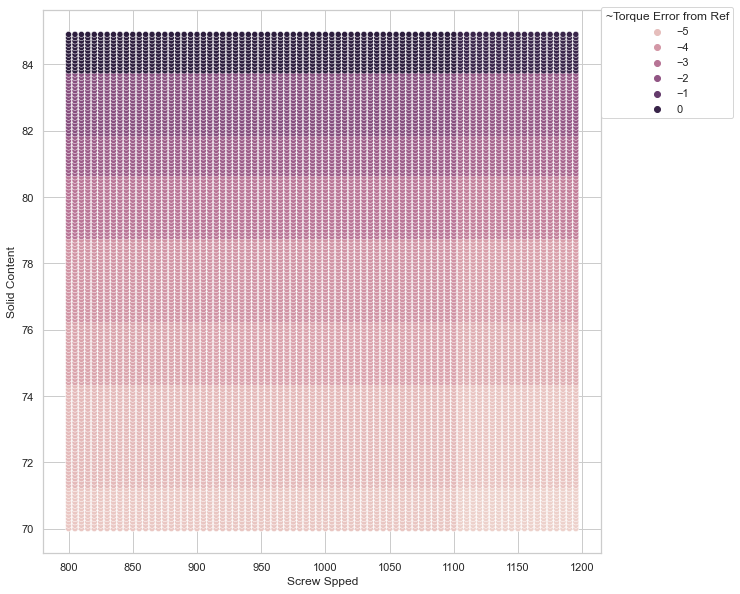

In [165]:
extruder.plot_all_torques(8.1217 , size = 10)

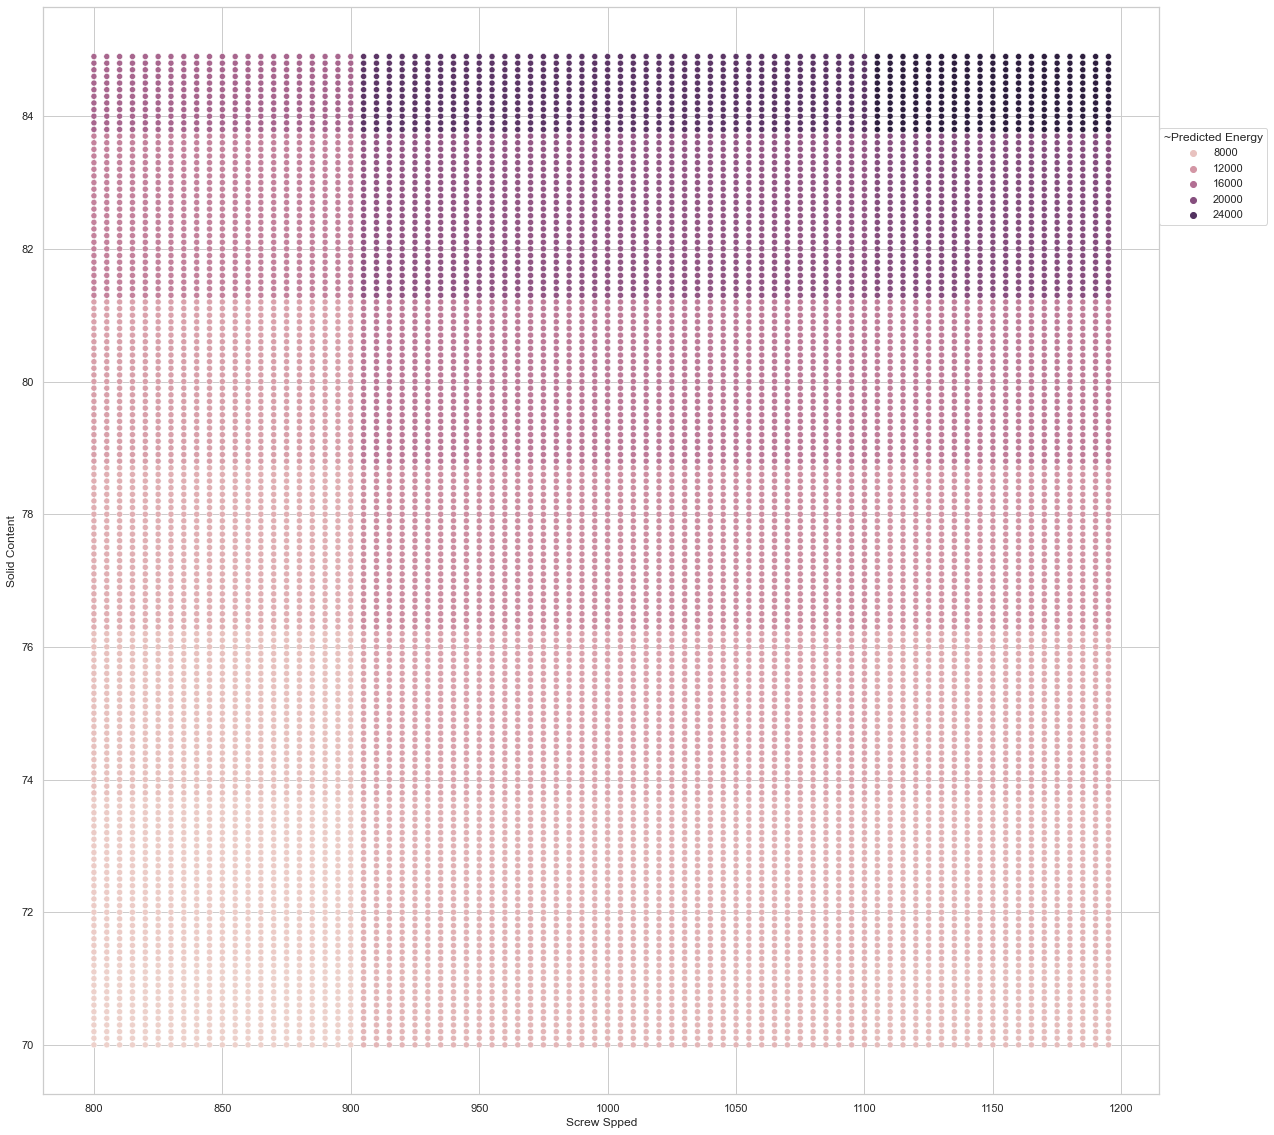

In [167]:
extruder.plot_all_energies()

C:\Users\aminr\AppData\Local\Temp\ipykernel_4716\3313914525.py:213: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = ax.figure.colorbar(sm)


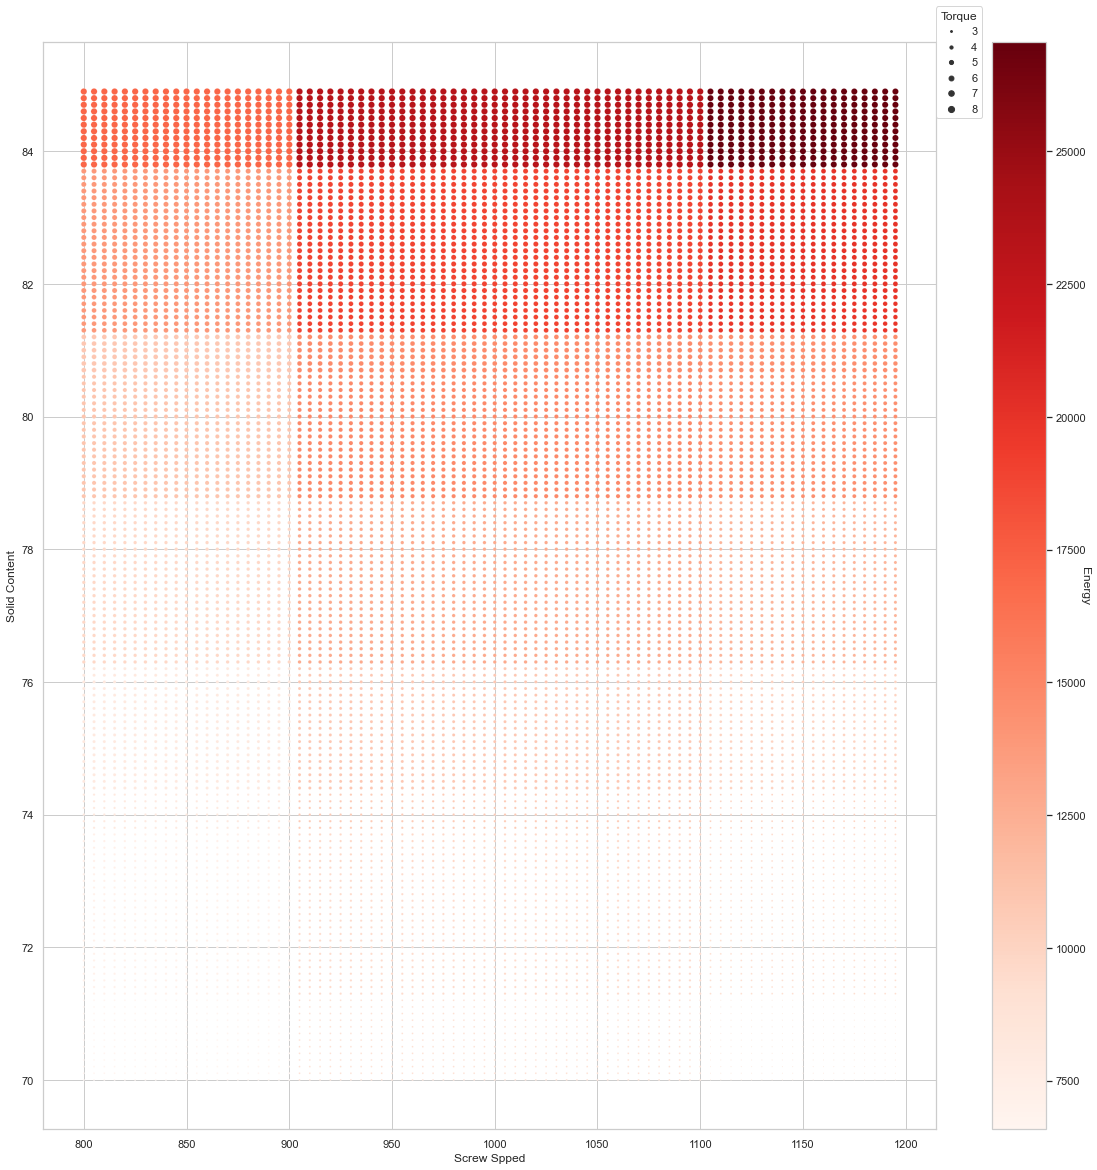

<Figure size 432x288 with 0 Axes>

In [168]:
extruder.plot_mixed()

In [32]:
np.unique(extruder.torques_space)

array([2.64951222, 2.92817026, 2.94865081, 2.97560328, 2.99502882,
       3.25426132, 3.27368686, 3.27474188, 3.29416742, 3.55151642,
       3.83017446, 3.85065502, 3.94522869, 4.22388673, 4.24436728,
       4.78890493, 5.06756297, 5.08804352, 5.56600409, 5.84466213,
       5.86514268, 6.06745484, 6.34611288, 6.36659344, 8.07935544,
       8.35801348, 8.37849403])

In [33]:
np.unique(extruder.energies_space)

array([ 6584.0495237 ,  7081.11181268,  7182.60917816,  8047.27073759,
        8066.76627566,  8635.26221859,  9011.47976441,  9266.40769096,
        9395.3721842 ,  9493.92261688,  9760.81383297,  9767.14116328,
       10023.97736367, 10206.85237456, 10637.10124246, 10839.47808863,
       10880.78999521, 11041.34429148, 12137.46648183, 12748.91829477,
       13877.13906846, 13896.00528237, 14484.56445739, 14578.47532633,
       14681.94217094, 14882.89696726, 16996.28964387, 18879.15069294,
       18929.75350529, 19803.60973146, 19991.26691269, 23293.0261527 ,
       27053.822557  ])

C:\Users\aminr\AppData\Local\Temp\ipykernel_4716\1523099744.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = ax.figure.colorbar(sm)


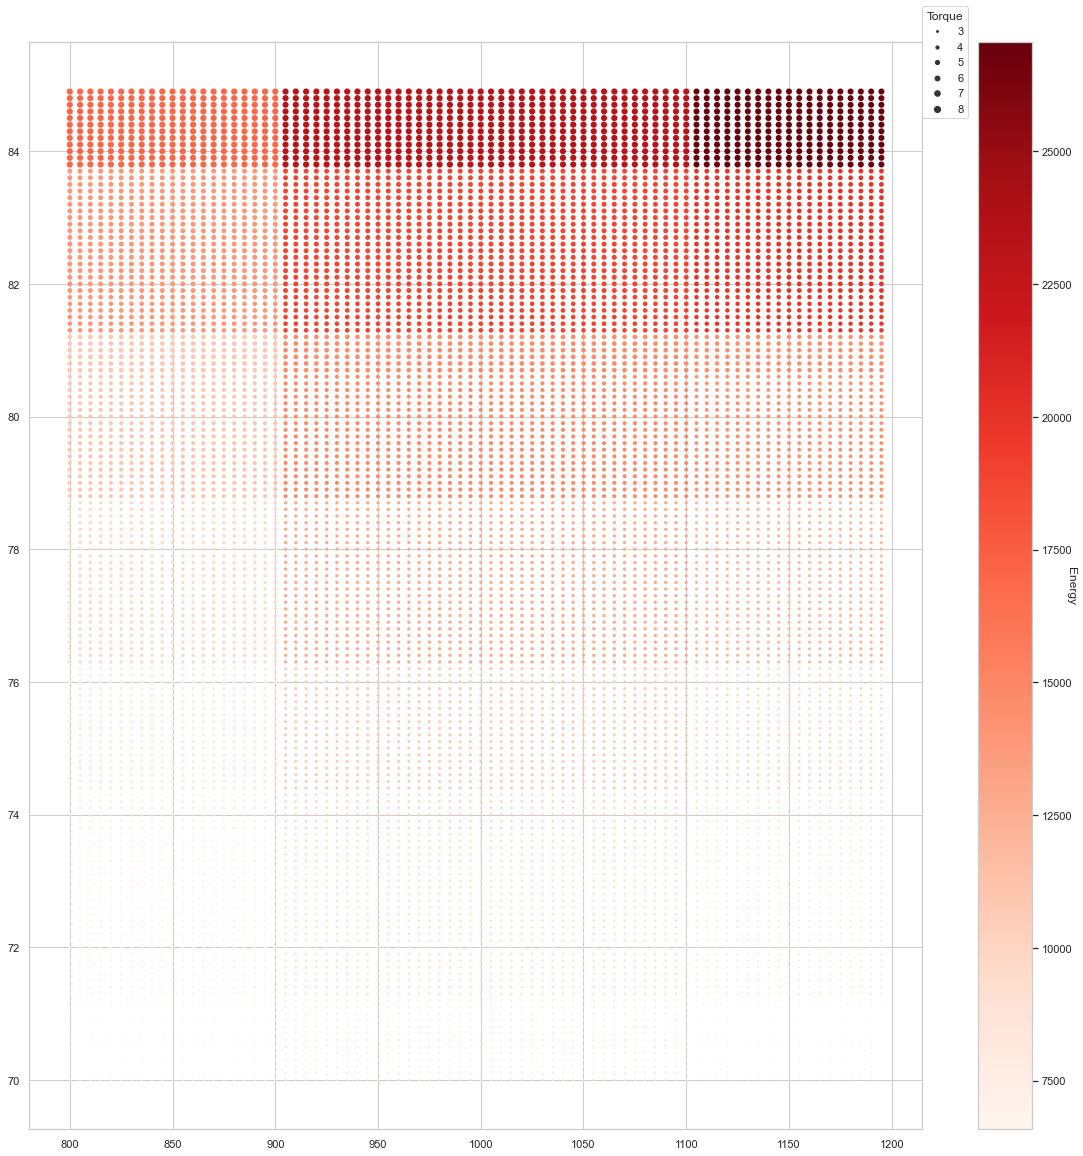

In [121]:
import matplotlib.pyplot as plt
fig , ax = plt.subplots(1,1,figsize= (20,20))
norm = plt.Normalize(extruder.energies_space.min(), extruder.energies_space.max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm )
sm.set_array([])

sns.set_theme(style="whitegrid")
# cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
# ax = sns.relplot(x = extruder.potentail_screw_speed , y = extruder.potentail_solid_content,height=15 , hue = (extruder.energies_space ),palette=cmap ,sizes=(1, 40), size= extruder.torques_space  ,legend="full")
ax = sns.scatterplot(x = extruder.potentail_screw_speed , y = extruder.potentail_solid_content , hue = (extruder.energies_space ),sizes=(1, 40), size= extruder.torques_space,palette='Reds'  )



black = [[0.2, 0.2, 0.2, 1. ]]
handles = []
for h in ax.get_legend_handles_labels()[0]:
    h_color = h.get_facecolor()
    # print(h.get_facecolor() )
    if np.array_equal(h_color , black):
        handles.append(h)


ax.legend(handles=handles , title = "Torque" , loc = (1,0.93))
# handles, labels = ax.get_legend_handles_labels()
# ax.set_ylabel('n passengers')
# ax.get_legend().remove()
cbar = ax.figure.colorbar(sm)
cbar.ax.set_ylabel('Energy' , rotation=270) #
# cbar.ax.set_xlabel('Energy') # , rotation=270

plt.show()

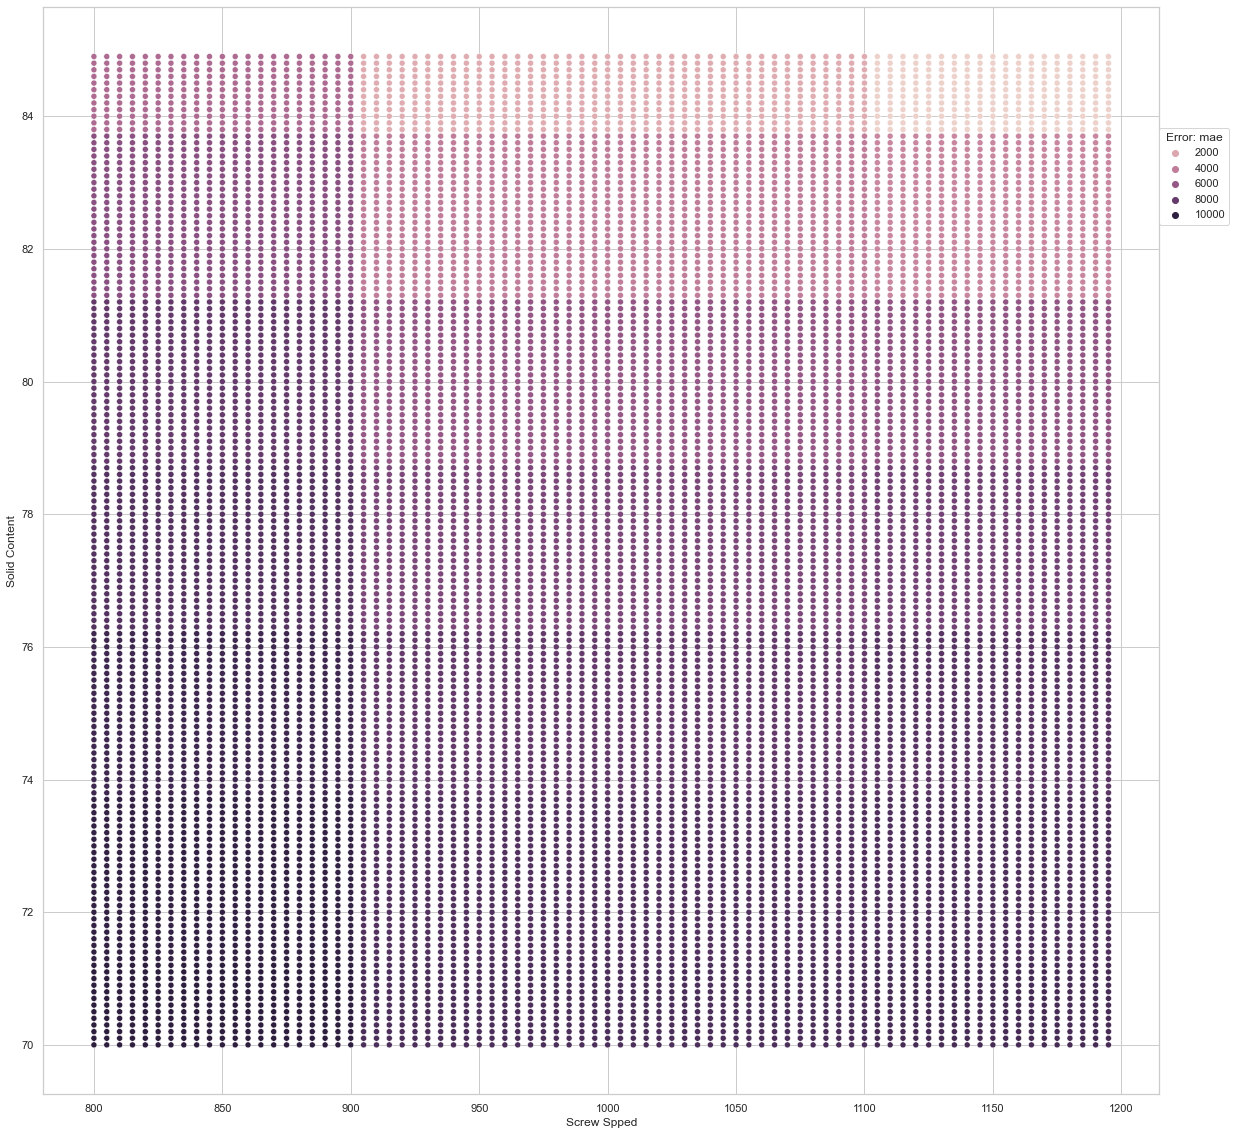

In [169]:
extruder.plt_vs_error()

In [ ]:
iris = sns.load_dataset('iris')
ax = sns.scatterplot(data=iris, x='sepal_length', y='petal_length', hue='species', size='sepal_width')
handles, labels = ax.get_legend_handles_labels()
for h in handles[-5:]: # changes the 5 last handles, this number might be different in your case
    h.set_facecolor('none')
ax.legend(handles=handles, labels=labels, bbox_to_anchor=[1.02, 1.02], loc='upper left')
plt.tight_layout()
plt.show()

In [91]:
ax.get_legend_handles_labels()[0][0].properties()["facecolor"]

array([[0.9979085 , 0.91686275, 0.87843137, 1.        ]])

In [92]:
ax.get_legend_handles_labels()[0][-1].properties()["facecolor"]

array([[0.2, 0.2, 0.2, 1. ]])

In [101]:
a = ax.get_legend_handles_labels()[0][-1].get_facecolor() 
b = [[0.2, 0.2, 0.2, 1. ]]

In [102]:
np.array_equal(a,b) 

True

In [108]:
black = [[0.2, 0.2, 0.2, 1. ]]
for h in ax.get_legend_handles_labels()[0]:
    h_color = h.get_facecolor()
    # print(h.get_facecolor() )
    if np.array_equal(h_color , black):
        print("blac")

    else:print("not black")

not black
not black
not black
not black
not black
blac
blac
blac
blac
blac
blac


In [109]:
black = [[0.2, 0.2, 0.2, 1. ]]
handles = []
for h in ax.get_legend_handles_labels()[0]:
    h_color = h.get_facecolor()
    # print(h.get_facecolor() )
    if np.array_equal(h_color , black):
        handles.append(h)

